In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [18]:
data = pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/최종_당뇨_고혈압_합본.csv")

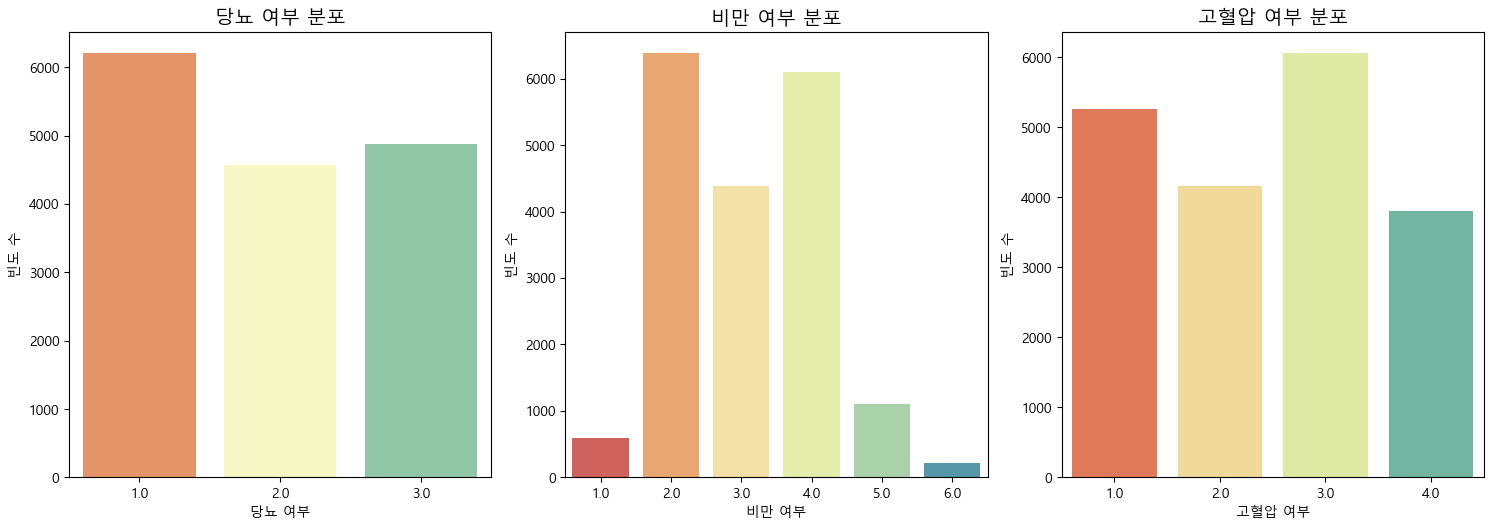

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': '당뇨 여부',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [20]:
# 공복혈당: 50 이상 & 350 이하
data = data[(data['HE_glu'] >= 50) & (data['HE_glu'] <= 350)]

# ALT (간수치): 400 미만
data = data[data['HE_alt'] < 400]

In [21]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [22]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'HE_HbA1c'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data

# knn_scaler_filename = 'HE_DM_HbA1c_knn_scaler.pkl'
# knn_imputer_filename = 'HE_DM_HbA1c_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_obe_knn_scaler.pkl'
# knn_imputer_filename = 'HE_obe_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_HP_knn_scaler.pkl'
# knn_imputer_filename = 'HE_HP_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)

print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

# 전처리 코드 끝에 추가
#data.to_csv('건강조사_2022~2023_통합(가공된).csv', index=False, encoding='utf-8-sig')

DE1_dg missing ratio: 0.00010137875101378751
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 63.2
Median for HE_ht: 162.4
Median for HE_BMI: 24.1000594121165
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_HbA1c          0
HE_chol           0
HE_HDL_st2        0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.470185
3.0    0.285615
2.0    0.244200
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.336941
4.0    0.317439
3.0    0.230163
5.0    0.057541
1.0    0.031

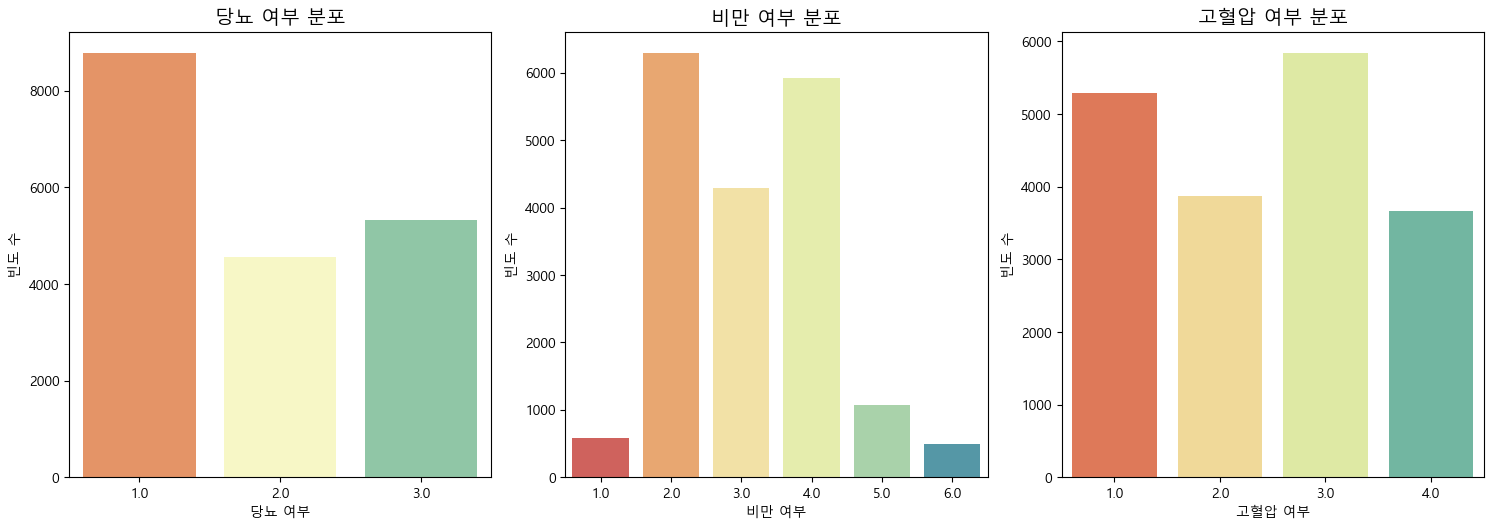

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': '당뇨 여부',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



▶ Mean F1 score (CV) of D_tree: 76.46%
▶ Test F1 score of D_tree: 77.14%
▶ Test Accuracy of D_tree: 77.18%

▶ Mean F1 score (CV) of RF: 77.35%
▶ Test F1 score of RF: 77.39%
▶ Test Accuracy of RF: 77.28%

▶ Mean F1 score (CV) of HistGB: 78.08%
▶ Test F1 score of HistGB: 78.40%
▶ Test Accuracy of HistGB: 78.49%

▶ Mean F1 score (CV) of XGB: 78.14%
▶ Test F1 score of XGB: 77.80%
▶ Test Accuracy of XGB: 78.03%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 11945, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` 

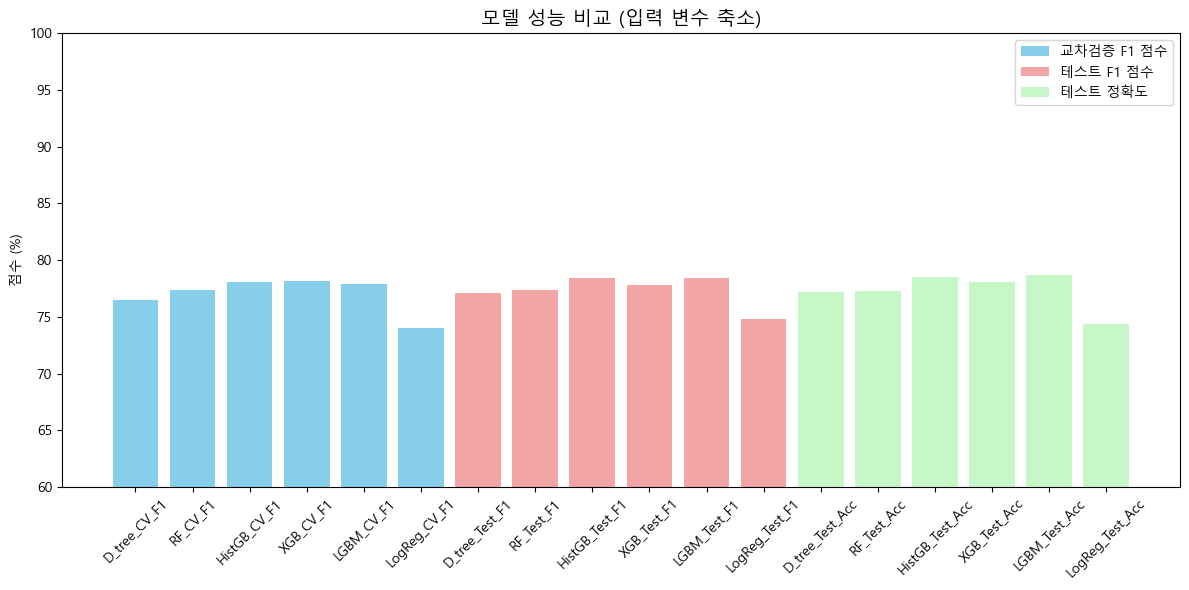

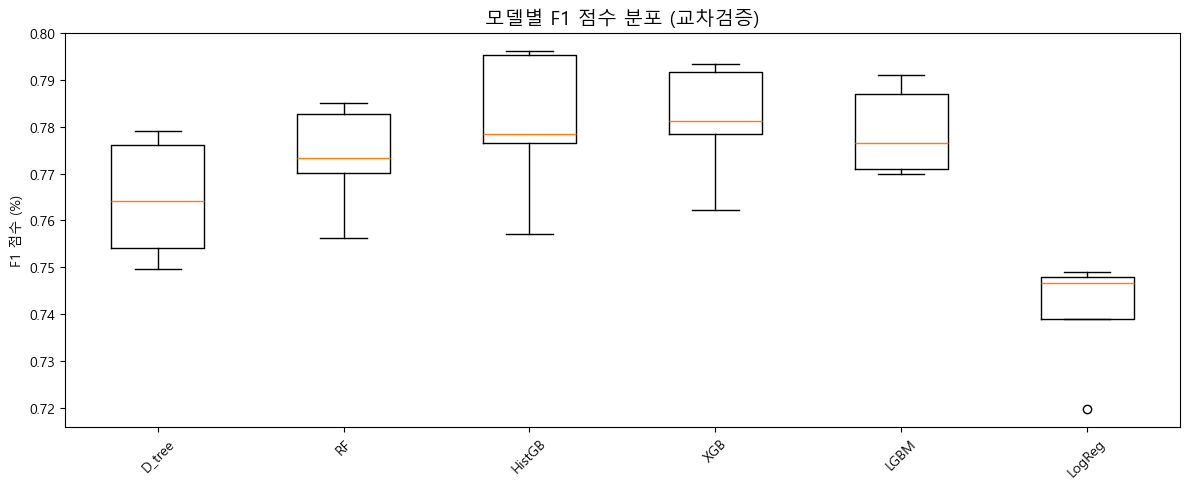

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_DM_HbA1c_input_features = ['HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age']
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot (CV F1 분포)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 점수 (%)')
ax.set_title('모델별 F1 점수 분포 (교차검증)', fontsize=14)
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

          정상       0.95      0.87      0.91      1755
      경계형 당뇨       0.75      0.88      0.81       912
          당뇨       0.90      0.89      0.90      1066

    accuracy                           0.88      3733
   macro avg       0.87      0.88      0.87      3733
weighted avg       0.89      0.88      0.88      3733



<Figure size 600x600 with 0 Axes>

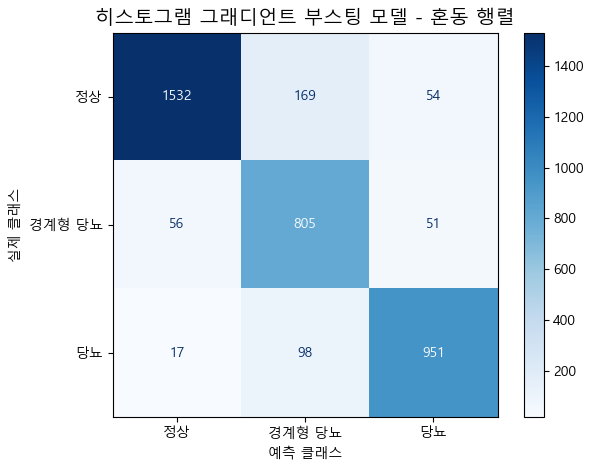

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

HE_DM_HbA1c_input_features = ['HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age','HE_HbA1c']

# X와 y 정의
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스 이름 한글로 정의
target_names_kor = ['정상', '경계형 당뇨', '당뇨']

# 평가 지표 출력 (한글 클래스명)
print(classification_report(y_test, y_pred, target_names=target_names_kor))

# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 혼동 행렬 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names_kor)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("히스토그램 그래디언트 부스팅 모델 - 혼동 행렬", fontsize=14)
plt.xlabel("예측 클래스")
plt.ylabel("실제 클래스")
plt.tight_layout()
plt.show()

# classification_report DataFrame 변환 (선택)
class_report = classification_report(y_test, y_pred, target_names=target_names_kor, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()



In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 다중 클래스 (0: 정상, 1: 경계형, 2: 당뇨) → One-vs-Rest용 이진 매트릭스로 변환
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_proba = best_model.predict_proba(X_test_scaled)

# ROC AUC Score 계산 (macro)
roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"Macro ROC AUC Score: {roc_auc_macro:.4f}")


Macro ROC AUC Score: 0.9709


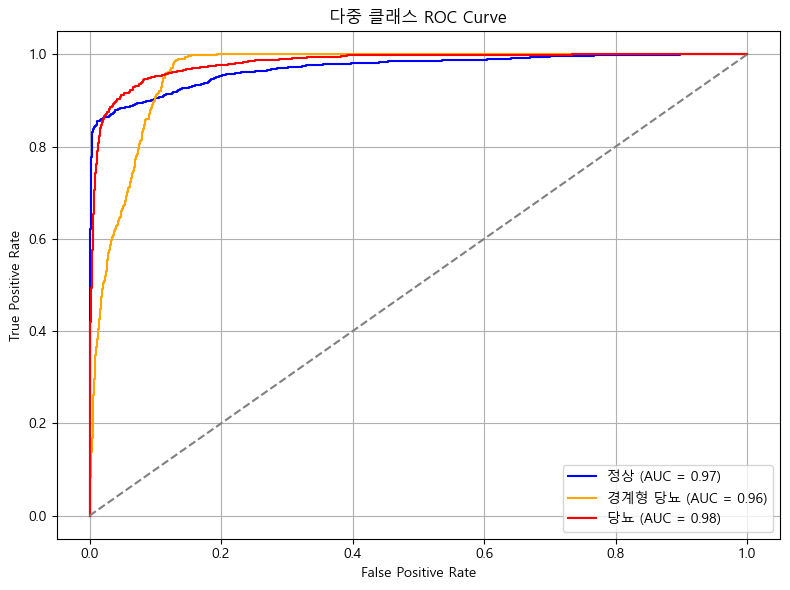

In [36]:
# 클래스 이름 한글
class_names = ['정상', '경계형 당뇨', '당뇨']
colors = ['blue', 'orange', 'red']

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("다중 클래스 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



▶ Mean F1 score (CV) of D_tree: 68.95%
▶ Test F1 score of D_tree: 69.17%
▶ Test Accuracy of D_tree: 69.30%

▶ Mean F1 score (CV) of RF: 70.52%
▶ Test F1 score of RF: 71.25%
▶ Test Accuracy of RF: 71.77%

▶ Mean F1 score (CV) of HistGB: 73.38%
▶ Test F1 score of HistGB: 74.01%
▶ Test Accuracy of HistGB: 74.02%

▶ Mean F1 score (CV) of XGB: 72.59%
▶ Test F1 score of XGB: 73.72%
▶ Test Accuracy of XGB: 73.77%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 11945, number of used features: 12
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

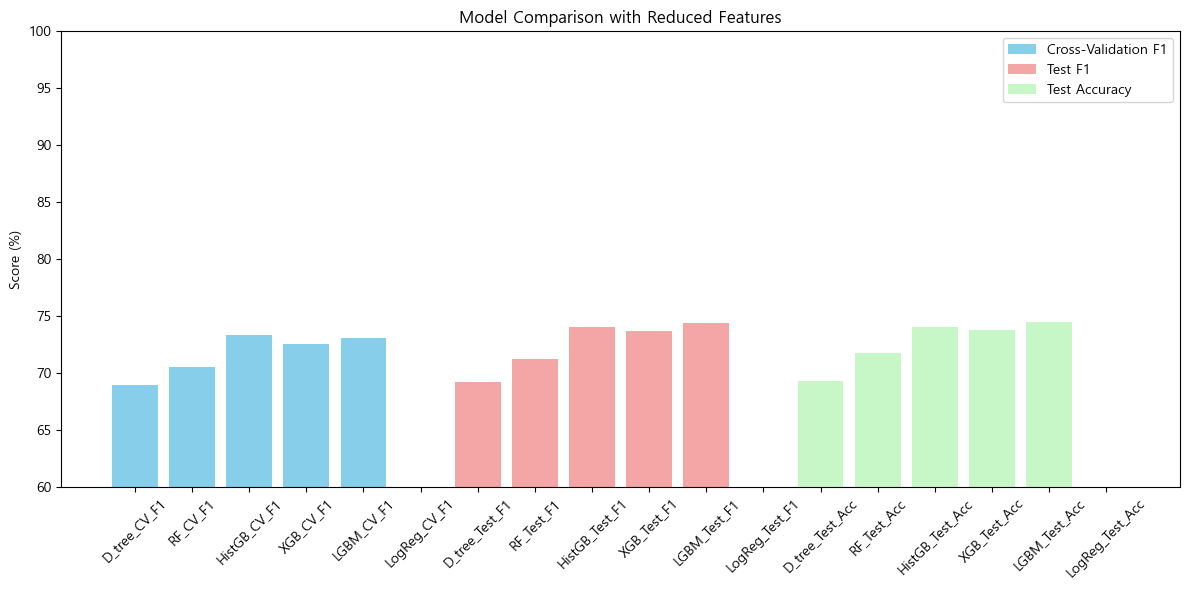

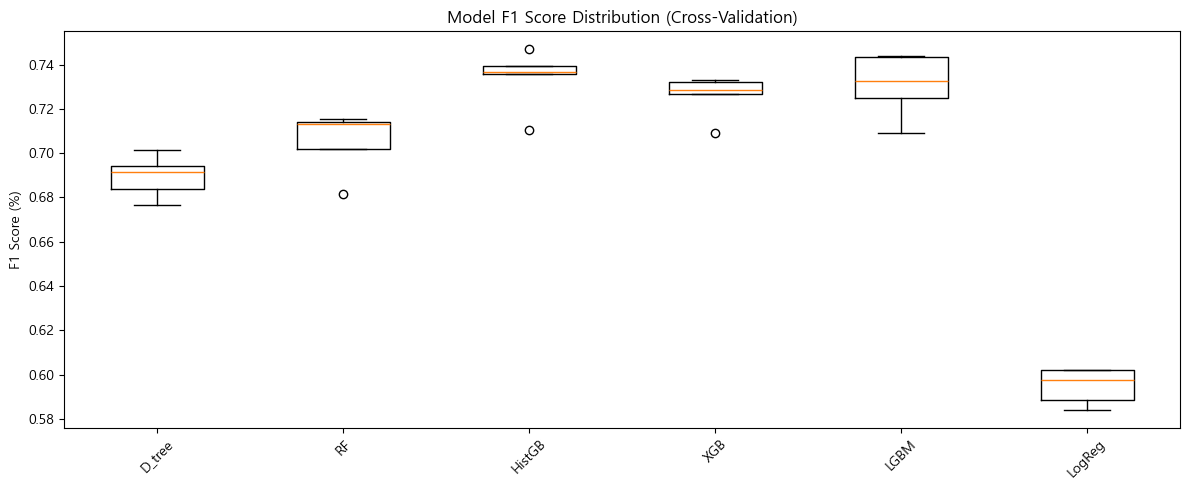

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()


                       precision    recall  f1-score   support

     Class 0 (Normal)       0.85      0.81      0.83      1057
     Class 1 (Pre_hp)       0.69      0.78      0.73       775
Class 2 (Pre_high_hp)       0.75      0.74      0.74      1168
    Class 3 (High_hp)       0.64      0.61      0.62       733

             accuracy                           0.74      3733
            macro avg       0.73      0.73      0.73      3733
         weighted avg       0.74      0.74      0.74      3733



<Figure size 600x600 with 0 Axes>

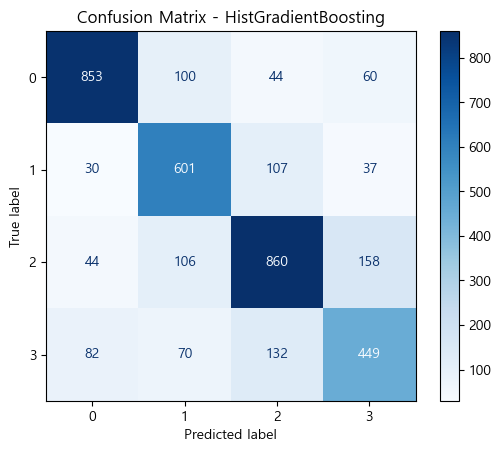

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스별 F1 스코어 출력
print(classification_report(y_test, y_pred, target_names=['Class 0 (Normal)', 'Class 1 (Pre_hp)', 'Class 2 (Pre_high_hp)', 'Class 3 (High_hp)']))

# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']
#'age'
# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용


from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

# 클래스 가중치 계산 ('balanced'는 빈도수에 반비례하여 자동 계산)
# compute_class_weight 함수에 원본 훈련 데이터의 y 값을 전달해야 합니다.
# 만약 SMOTE 적용 후의 데이터로 가중치를 계산하고 싶다면 y_train_smote를 전달합니다.
classes = np.unique(y_train) # 원본 훈련 데이터의 클래스 레이블
weights = compute_class_weight('balanced', classes=classes, y=y_train)

# 계산된 가중치를 딕셔너리 형태로 변환 {클래스_라벨: 가중치}
class_weights_dict = dict(zip(classes, weights))

print(f"계산된 클래스 가중치: {class_weights_dict}")


# HistGradientBoostingClassifier 모델 학습 (class_weight 적용)
# best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42) # 기존 모델
# class_weight 매개변수 추가
best_model_weighted = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    random_state=42,
    class_weight="balanced" # 또는 'balanced' 문자열 사용 가능
)

# 스케일링된 훈련 데이터로 학습 (SMOTE 미적용 시 X_train_scaled 사용)
# 만약 SMOTE 결과를 사용한다면 X_train_smote_scaled (SMOTE 후 스케일링된 데이터) 사용
best_model_weighted.fit(X_train_scaled, y_train)

# 스케일링된 테스트 데이터로 예측
y_pred_weighted = best_model_weighted.predict(X_test_scaled)

# 성능 평가
print("\nClass Weight 적용 후 Classification Report:")
# y_test는 원본 테스트 데이터의 라벨입니다. 예측 결과와 비교합니다.
print(classification_report(y_test, y_pred_weighted))

# 추가적으로 F1 스코어를 각 클래스별로 확인하여 개선되었는지 비교합니다.
f1_weighted = f1_score(y_test, y_pred_weighted, average=None)
print(f"\nClass Weight 적용 후 클래스별 F1-score: {f1_weighted}")

계산된 클래스 가중치: {np.int64(0): np.float64(0.8825059101654846), np.int64(1): np.float64(1.2045821232655696), np.int64(2): np.float64(0.7993576017130621), np.int64(3): np.float64(1.2727582679849982)}

Class Weight 적용 후 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1057
           1       0.69      0.77      0.73       775
           2       0.74      0.72      0.73      1168
           3       0.62      0.57      0.60       733

    accuracy                           0.73      3733
   macro avg       0.72      0.72      0.72      3733
weighted avg       0.73      0.73      0.73      3733


Class Weight 적용 후 클래스별 F1-score: [0.81491974 0.73037127 0.73225947 0.59801136]


                       precision    recall  f1-score   support

     Class 0 (Normal)       0.82      0.83      0.83      1057
     Class 1 (Pre_hp)       0.71      0.77      0.74       775
Class 2 (Pre_high_hp)       0.72      0.78      0.75      1168
    Class 3 (High_hp)       0.66      0.51      0.58       733

             accuracy                           0.74      3733
            macro avg       0.73      0.72      0.72      3733
         weighted avg       0.74      0.74      0.73      3733



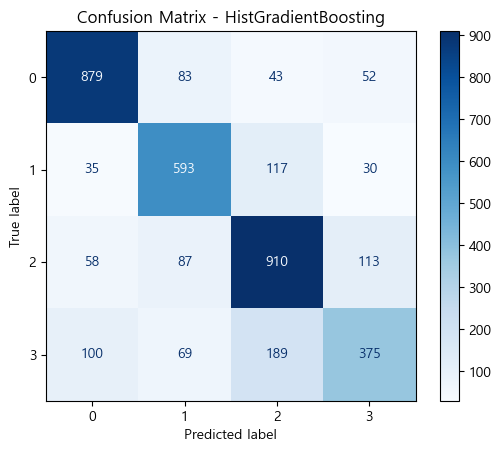

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. 구간화 함수 정의
def bin_sbp(value):
    if value < 120:
        return 0  # 정상
    elif value < 130:
        return 1  # 주의
    elif value < 140:
        return 2  # 고혈압 전단계
    else:
        return 3  # 고혈압

def bin_dbp(value):
    if value < 80:
        return 0
    elif value < 85:
        return 1
    elif value < 90:
        return 2
    else:
        return 3

# 2. 구간화 적용
data["sbp_bin"] = data["HE_sbp1"].apply(bin_sbp)
data["dbp_bin"] = data["HE_dbp1"].apply(bin_dbp)

# 3. 피처 선택 (구간화된 혈압 포함)
features = [
    'age', 'HE_sbp1', 'HE_dbp1',  # 원래 수치형 혈압도 포함
    'sbp_bin', 'dbp_bin',        # 구간화된 혈압도 같이 포함
    'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea',
    'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2'
]

X = data[features]
y = data['HE_HP'].astype(int) - 1  # 0~3 라벨

# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. 스케일링 (구간화된 값은 제외하거나 같이 처리해도 무방)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. 모델 정의 및 학습 (SMOTE 제거, class_weight 사용 가능)
model = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    random_state=42,
    verbose=0
)
model.fit(X_train_scaled, y_train)

# 7. 예측 및 평가
y_pred = model.predict(X_test_scaled)

print(classification_report(
    y_test, y_pred,
    target_names=['Class 0 (Normal)', 'Class 1 (Pre_hp)', 'Class 2 (Pre_high_hp)', 'Class 3 (High_hp)']
))

# 8. 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()


In [45]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight


HE_HP_input_features = ['HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'age', 'sex']

# HE_HP 데이터 처리
X_hp = data[HE_HP_input_features]
y_hp = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 (HE_HP)
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_hp, y_hp, stratify=y_hp, test_size=0.2, random_state=42)

# 스케일링 (HE_HP)
scaler_hp = StandardScaler()
X_train_hp_scaled = scaler_hp.fit_transform(X_train_hp)
X_test_hp_scaled = scaler_hp.transform(X_test_hp)

# SMOTE 적용 (HE_HP)
smote_hp = SMOTE(random_state=42)
X_train_hp_smote, y_train_hp_smote = smote_hp.fit_resample(X_train_hp_scaled, y_train_hp)

# 클래스 가중치 계산 (HE_HP)
classes = np.unique(y_train_hp) # 원본 훈련 데이터의 클래스 레이블
weights = compute_class_weight('balanced', classes=classes, y=y_train_hp)
# 계산된 가중치를 딕셔너리 형태로 변환 {클래스_라벨: 가중치}
class_weights_dict_hp = dict(zip(classes, weights))

# 모델 정의 (HistGradientBoostingClassifier)
base_model_hp = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    max_depth=5,
    min_samples_leaf=20,
    l2_regularization=1.0,
    random_state=0,
    class_weight=class_weights_dict_hp
)

#모델 훈련
#(HE_HP)
model_hp = CalibratedClassifierCV(base_model_hp, method='sigmoid', cv=5)
model_hp.fit(X_train_hp_smote, y_train_hp_smote)

#테스트 데이터 평가
#(HE_HP)
y_pred_hp = model_hp.predict(X_test_hp_scaled)
print("HE_HP Classification Report:")
print(classification_report(y_test_hp, y_pred_hp, target_names=['Normal', 'Pre-hp', 'Pre-high-hp', 'High-hp']))




HE_HP Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.82      0.83      1057
      Pre-hp       0.69      0.79      0.74       775
 Pre-high-hp       0.77      0.72      0.75      1168
     High-hp       0.64      0.62      0.63       733

    accuracy                           0.74      3733
   macro avg       0.73      0.74      0.74      3733
weighted avg       0.75      0.74      0.74      3733



In [48]:
from sklearn.model_selection import GridSearchCV
import os
os.environ["PYTHONIOENCODING"] = "utf-8"
import logging
logging.getLogger().setLevel(logging.WARNING)
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight


HE_HP_input_features = ['HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'age', 'sex']

# HE_HP 데이터 처리
X_hp = data[HE_HP_input_features]
y_hp = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 (HE_HP)
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_hp, y_hp, stratify=y_hp, test_size=0.2, random_state=42)

# 스케일링 (HE_HP)
scaler_hp = StandardScaler()
X_train_hp_scaled = scaler_hp.fit_transform(X_train_hp)
X_test_hp_scaled = scaler_hp.transform(X_test_hp)

# SMOTE 적용 (HE_HP)
smote_hp = SMOTE(random_state=42)
X_train_hp_smote, y_train_hp_smote = smote_hp.fit_resample(X_train_hp_scaled, y_train_hp)


# 파라미터 그리드 정의
param_grid = {
    'base_estimator__learning_rate': [0.01, 0.1, 0.2],
    'base_estimator__max_iter': [100, 200, 300],
    'base_estimator__max_depth': [3, 5, 7],
    'base_estimator__min_samples_leaf': [10, 20, 30],
    'base_estimator__l2_regularization': [0.0, 0.5, 1.0]
}

# 모델 정의 (CalibratedClassifierCV 사용)
base_model_hp = HistGradientBoostingClassifier(random_state=0, class_weight=class_weights_dict_hp)
model_hp = CalibratedClassifierCV(base_model_hp, method='sigmoid', cv=5)

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=model_hp,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',  # 클래스 불균형 고려
    n_jobs=-1
)

# 모델 학습
grid_search.fit(X_train_hp_smote, y_train_hp_smote)

# 최적 파라미터 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# 최적 모델로 예측
best_model_hp = grid_search.best_estimator_
y_pred_hp = best_model_hp.predict(X_test_hp_scaled)

# 성능 평가
print("HE_HP Classification Report (Tuned):")
print(classification_report(y_test_hp, y_pred_hp, target_names=['Normal', 'Pre-hp', 'Pre-high-hp', 'High-hp']))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [49]:
print("Columns:", data.columns)
print("Sample data:", data.head().to_string())

Columns: Index(['ID', 'year', 'age', 'sex', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
       'HE_sbp1', 'HE_dbp1', 'HE_Upro', 'HE_glu', 'HE_HbA1c', 'HE_chol',
       'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
       'HE_obe', 'HE_HP', 'HE_DM_HbA1c', 'DE1_dg', 'DI1_dg', 'HE_BMI_imputed',
       'sbp_bin', 'dbp_bin'],
      dtype='object')
Sample data:            ID    year   age  sex  HE_ht  HE_wt  HE_wc     HE_BMI  HE_sbp1  HE_dbp1  HE_Upro  HE_glu  HE_HbA1c  HE_chol  HE_HDL_st2  HE_TG  HE_LDL_drct  HE_crea  HE_ast  HE_alt  HE_obe  HE_HP  HE_DM_HbA1c  DE1_dg  DI1_dg  HE_BMI_imputed  sbp_bin  dbp_bin
0  YA01220302  2022.0  56.0  2.0  151.2   60.6   84.3  26.507517    135.0     90.0      0.0    94.0       5.6    199.0        56.0  181.0        122.0     0.61    22.0    16.0     4.0    4.0          1.0     0.0     1.0               0        2        3
1  YA01220303  2022.0  30.0  1.0  174.1   82.3   86.2  27.152029    145.0     77.0      0.0    84.0       5.3    122.0